# Temperature depth Features SHAP analisys
## Climate change models for the gulf of california

Deep Dive into Methodology and SHAP Analysis Using the Implemented Code
1. Introduction
The code is designed to analyze the impact of input features on predictions generated by a neural network model trained for fisheries data forecasting. Specifically, it uses SHAP (SHapley Additive exPlanations) to explain model predictions by computing the contribution of each feature. The goal is to provide a detailed analysis across different decades (2020 to 2060) and to visualize the evolution of feature importance over time.

2. Data Pipeline and Preprocessing
The input data consists of:

Historical data: This is used to fit the model and contains various time series features related to environmental conditions and fishery-related metrics.
Future data: The future data is forecasted or assumed environmental variables for the coming decades.
The relevant features include:

Landed weight (landed_w_kg): A measure of the total weight of fish landed.
Cluster Label (Cluster_Label): Identifies the cluster to which the data point belongs.
Temperature Features: Including measurements at different depths, such as mean_temp_30m, mean_temp_10m, and several thetao_sfc features, representing surface and sub-surface sea temperatures.
The data is scaled using a pre-trained scaler to ensure that the features are normalized before being fed into the model. The features are renamed to match the format expected by the model.

3. Model and Feature Set
The model used is a neural network (Keras model) that takes in time-series input with a shape of (None, 6, 14), meaning 6 time steps and 14 features. The features include:

Landed weight (landed_w_kg)
Cluster label
Sea temperatures at various depths and specific points
Historical information about fish catches
The neural network uses these features to predict future fish catches or landed weights. The model predicts based on time series inputs, considering both historical and projected environmental conditions.

4. SHAP Analysis Framework
SHAP (SHapley Additive exPlanations) is a game-theoretic approach to explaining the output of machine learning models. SHAP values quantify the contribution of each feature to the final prediction. Positive SHAP values indicate that the feature contributed to increasing the prediction, while negative values indicate a contribution to decreasing the prediction.

5. GradientExplainer for Neural Networks
The code leverages shap.GradientExplainer due to its compatibility with neural networks trained using gradient-based optimizers (such as Keras and TensorFlow). GradientExplainer uses model gradients to compute feature attributions, which allows it to efficiently explain predictions for complex models with differentiable components.

6. Key Steps in the Code
6.1 Data Loading
The code first loads both the historical predictions and future data, which will be used for SHAP analysis.
It also loads the pre-trained model and scaler from saved files.
6.2 Data Preprocessing
The future data is transformed (scaled) using a pre-trained scaler. This ensures that the input data is normalized in the same way as the training data used to fit the model.
Missing or default values are handled, such as setting the landed_w_kg to 0 for future projections, as these values are unknown.
6.3 SHAP Computation
Background Data: A subset of the scaled future data is selected as "background" data for SHAP analysis. The background data provides a reference for SHAP value computations.
Time Series Input: The time series input is reshaped to match the model’s expected input format (6 time steps and 14 features).
SHAP Values: The SHAP values are computed for each input using shap.GradientExplainer, which computes the gradient of the model output with respect to each feature for each time step. This explains how much each feature at each time step contributes to the prediction.
6.4 Analysis Over Time
The SHAP values are computed for multiple decades (2020, 2030, 2040, 2050, 2060). For each decade, the feature contributions are averaged over the time series, providing a global explanation of how feature importance changes over time.

SHAP values are averaged: For each feature and for each decade, the SHAP values across the 6 time steps are averaged. This gives a single SHAP value per feature per decade.
Decadal Analysis: The code computes and stores the SHAP values for each feature at different time intervals to understand how their importance evolves over time.
6.5 Output Generation
CSV Export: The computed SHAP values are saved into a CSV file for further analysis or reporting.
Visualization: A scatter plot is generated where the x-axis represents the decades, and the y-axis represents the average SHAP values. This visualizes the evolution of feature importance across time.
Saving the Plot: The plot is saved as a PNG file, allowing for easy sharing and reporting.
7. Visualization of SHAP Values
The output visualization shows:

Feature Importance Over Time: For each feature, the average SHAP value across decades is plotted, giving insight into whether the influence of certain features is increasing or decreasing as time progresses.
Trend Analysis: The scatter plot makes it easy to see trends. For example, if a certain sea temperature depth becomes more or less influential over time, it will be reflected in the graph.
8. Deep Dive into SHAP Interpretation
Interpreting SHAP values requires understanding that SHAP represents the contribution of each feature to the prediction. A higher SHAP value for a feature in a certain decade means that the feature was a more important driver of the predicted landed weight (or fish catch) for that period.

Key features to watch:

Temperature Features: Since temperature plays a critical role in fisheries, SHAP values for different sea temperature depths (e.g., mean_temp_30m, thetao_sfc=7.93, etc.) are especially important. Their SHAP values across decades indicate how changes in sea temperature may influence fish population predictions.
Cluster Label: SHAP values for the cluster label can show how specific clusters (representing groups of similar data points) influence predictions over time.
Landed Weight: This feature represents the historical fish catch. Its SHAP value indicates how much historical catches contribute to future predictions.
9. Conclusion
The implemented methodology leverages the power of neural networks to predict fishery outcomes based on time series data and uses SHAP to explain the contributions of various environmental and historical factors to the model’s predictions. By computing SHAP values across multiple decades, the methodology allows for an in-depth analysis of how feature importance evolves over time. This information can be critical for understanding future trends in fisheries and guiding management decisions.

Key takeaways:

Feature importance evolves over time, allowing stakeholders to understand which factors will likely be more critical in future fishery management.
Temperature features at different depths play a key role in model predictions and understanding their influence can help predict changes in fish populations as the climate changes.
Historical catch data provides a strong baseline, and its influence relative to environmental conditions can give insights into the sustainability of fish stocks under different scenarios.
This analysis can be extended by testing other species, clusters, or environmental scenarios to provide broader insights into the future of fisheries.

In [1]:
import os
import numpy as np
import pandas as pd
import joblib
import tensorflow as tf
import shap
import matplotlib.pyplot as plt
import matplotlib
from tensorflow.keras.models import load_model

def run_shap_analysis(species, cluster):
    # Create the output folder if it doesn't exist
    results_dir = 'SHAP_results'
    if not os.path.exists(results_dir):
        os.makedirs(results_dir)
    
    # File paths for saving SHAP data and plot
    shap_csv_path = os.path.join(results_dir, f'{species}_cluster_{cluster}_shap_values_unscaled.csv')
    plot_path = os.path.join(results_dir, f'{species}_cluster_{cluster}_shap_plot_unscaled.png')
    
    # Dynamically set the file paths based on the species and cluster
    predictions_file = f'resultados_moe/{species}_cluster_{cluster}_predictions.csv'
    future_data_file = 'future_data.csv'
    model_path = f'modelos_moe/{species}_cluster_{cluster}_moe_model.h5'
    scaler_path = f'modelos_moe/{species}_cluster_{cluster}_moe_scaler.pkl'

    # Load the prediction and future data
    predictions_df = pd.read_csv(predictions_file)
    future_data = pd.read_csv(future_data_file)

    # Load the model and scaler
    model = load_model(model_path)
    scaler = joblib.load(scaler_path)

    # Column renaming to match the model input
    column_name_mapping = {
        'cluster': 'Cluster_Label',
        'depth_mean_30m': 'mean_temp_30m',
        'depth_mean_10m': 'mean_temp_10m',
        'depth_6.00': 'thetao_sfc=6',
        'depth_7.93': 'thetao_sfc=7.92956018447876',
        'depth_9.57': 'thetao_sfc=9.572997093200684',
        'depth_11.40': 'thetao_sfc=11.40499973297119',
        'depth_13.47': 'thetao_sfc=13.46714019775391',
        'depth_15.81': 'thetao_sfc=15.8100700378418',
        'depth_18.50': 'thetao_sfc=18.49555969238281',
        'depth_21.60': 'thetao_sfc=21.59881973266602',
        'depth_25.21': 'thetao_sfc=25.21141052246094',
        'depth_29.44': 'thetao_sfc=29.44473075866699'
    }
    
    # Rename columns in future data
    future_data.rename(columns=column_name_mapping, inplace=True)
    
    # Add missing columns with default values
    future_data['Cluster_Label'] = cluster
    future_data['landed_w_kg'] = 0  # Default value for landed weight

    # Features used in the model
    features = ['landed_w_kg', 'Cluster_Label', 'mean_temp_30m', 'mean_temp_10m', 'thetao_sfc=6',
                'thetao_sfc=7.92956018447876', 'thetao_sfc=9.572997093200684', 'thetao_sfc=11.40499973297119',
                'thetao_sfc=13.46714019775391', 'thetao_sfc=15.8100700378418', 'thetao_sfc=18.49555969238281',
                'thetao_sfc=21.59881973266602', 'thetao_sfc=25.21141052246094', 'thetao_sfc=29.44473075866699']

    # Scale the future data
    future_data_scaled = scaler.transform(future_data[features])

    # --- Inverse transform the scaled data back to the original scale ---
    future_data_unscaled = scaler.inverse_transform(future_data_scaled)

    # --- Use unscaled data for SHAP analysis ---
    # We use the unscaled input data for SHAP, so that the SHAP values will also be in the original scale
    # Reshape background data to match LSTM input shape
    look_back = 6
    if len(future_data_unscaled) >= look_back:
        background_unscaled = []
        for i in range(len(future_data_unscaled) - look_back + 1):
            background_unscaled.append(future_data_unscaled[i:i + look_back])
        background_unscaled = np.array(background_unscaled)
    else:
        raise ValueError("Not enough data to create the background set for SHAP analysis.")

    # Prepare SHAP inputs for analysis (unscaled)
    X_input_unscaled = future_data_unscaled[:look_back]
    X_input_unscaled = np.reshape(X_input_unscaled, (1, look_back, len(features)))

    # Create the explainer with GradientExplainer
    explainer = shap.GradientExplainer(model, background_unscaled)

    # Compute SHAP values for the input (unscaled data)
    shap_values = explainer.shap_values(X_input_unscaled)

    # Define short names for features
    short_feature_names = {
        'landed_w_kg': 'LW',
        'Cluster_Label': 'CL',
        'mean_temp_30m': 'Temp_30m',
        'mean_temp_10m': 'Temp_10m',
        'thetao_sfc=6': 'D06',
        'thetao_sfc=7.92956018447876': 'D07.93',
        'thetao_sfc=9.572997093200684': 'D09.57',
        'thetao_sfc=11.40499973297119': 'D11.40',
        'thetao_sfc=13.46714019775391': 'D13.47',
        'thetao_sfc=15.8100700378418': 'D15.81',
        'thetao_sfc=18.49555969238281': 'D18.50',
        'thetao_sfc=21.59881973266602': 'D21.60',
        'thetao_sfc=25.21141052246094': 'D25.21',
        'thetao_sfc=29.44473075866699': 'D29.44'
    }

    # Analyze SHAP values across decades (with unscaled data)
    decades_to_analyze = [2020, 2030, 2040, 2050, 2060]
    shap_values_over_time = {feature: [] for feature in features}

    # Calculate the average SHAP values for each decade (on unscaled data)
    for year in decades_to_analyze:
        year_index = year - 2020
        if year_index + look_back <= len(future_data_unscaled):
            X_year_unscaled = future_data_unscaled[year_index:year_index + look_back]
            X_year_unscaled = np.reshape(X_year_unscaled, (1, look_back, len(features)))
            shap_values_year = explainer.shap_values(X_year_unscaled)
            shap_values_year_mean = np.mean(np.abs(shap_values_year), axis=1)
            for i, feature in enumerate(features):
                shap_values_over_time[feature].append(shap_values_year_mean[0][i])

    # Save SHAP values as CSV (unscaled)
    shap_df = pd.DataFrame(shap_values_over_time, index=decades_to_analyze)
    shap_df.to_csv(shap_csv_path)
    print(f"SHAP values saved to: {shap_csv_path}")

    # Plot SHAP values over decades (unscaled)
    cmap = matplotlib.colormaps['tab20']
    colors = cmap(np.linspace(0, 1, len(features)))

    plt.figure(figsize=(10, 6))
    for i, feature in enumerate(features):
        if len(shap_values_over_time[feature]) == len(decades_to_analyze):
            plt.scatter(decades_to_analyze, shap_values_over_time[feature], label=short_feature_names[feature], color=colors[i])

    # Configure the plot
    plt.xlabel('Decade', fontsize=12)
    plt.ylabel('Average SHAP Value', fontsize=12)
    plt.title(f'SHAP Value by Feature Over the Decades ({species} cluster {cluster})', fontsize=14)
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1), title="Features", fontsize=10)
    plt.grid(True)
    plt.tight_layout()

    # Save the plot as an image
    plt.savefig(plot_path)
    print(f"SHAP plot saved to: {plot_path}")

    # Show the plot
    plt.show()

    # Print total SHAP value for each feature
    total_shap_values = {feature: np.sum(shap_values_over_time[feature]) for feature in features}
    print("Total SHAP values for each feature:")
    for feature, value in total_shap_values.items():
        print(f"{short_feature_names[feature]}: {value}")


c:\Users\ricar\anaconda3\envs\Pro24\Lib\site-packages\keras\src\backend.py:452: UserWarning: `tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
  warnings.warn(


SHAP values saved to: SHAP_results\JAIBA_cluster_7_shap_values_unscaled.csv
SHAP plot saved to: SHAP_results\JAIBA_cluster_7_shap_plot_unscaled.png


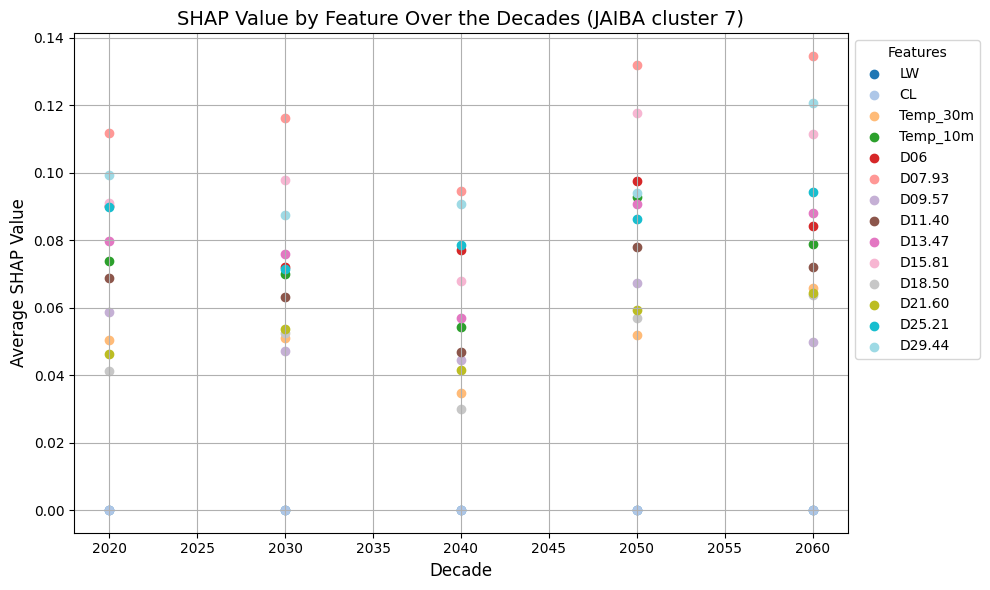

Total SHAP values for each feature:
LW: 0.0
CL: 0.0
Temp_30m: 0.25377514948680374
Temp_10m: 0.3695583787436287
D06: 0.42142063908977434
D07.93: 0.5892228137915178
D09.57: 0.2671560438951322
D11.40: 0.32847173050201184
D13.47: 0.3913434188192089
D15.81: 0.4861289216205477
D18.50: 0.24418331612832844
D21.60: 0.26508295404103893
D25.21: 0.4203547166932064
D29.44: 0.49221531394869095


In [2]:
run_shap_analysis('JAIBA','7')